In [1]:
import argparse
import numpy as np
from scipy.spatial.transform import Rotation as Rot
import pickle
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from typing import List
import open3d as o3d

from robot_utils.robot_data.pose_data import PoseData
from robot_utils.transform import transform_2_xytheta
from robot_utils.geometry import circle_intersection

from segment_track.segment import Segment
from segment_track.tracker import Tracker

from object_map_registration.object.ellipsoid import Ellipsoid
from object_map_registration.object.object import Object
from object_map_registration.object.pointcloud_object import PointCloudObject
from object_map_registration.register.dist_feature_sim_reg import DistOnlyReg, DistVolReg, DistFeaturePCAReg
from object_map_registration.register.dist_reg_with_pruning import DistRegWithPruning, GravityConstraintError
from object_map_registration.register.object_registration import InsufficientAssociationsException
from object_map_registration.utils import object_list_bounds
from open3d.web_visualizer import draw

%matplotlib widget

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


Loaded 76 and 72 submaps.


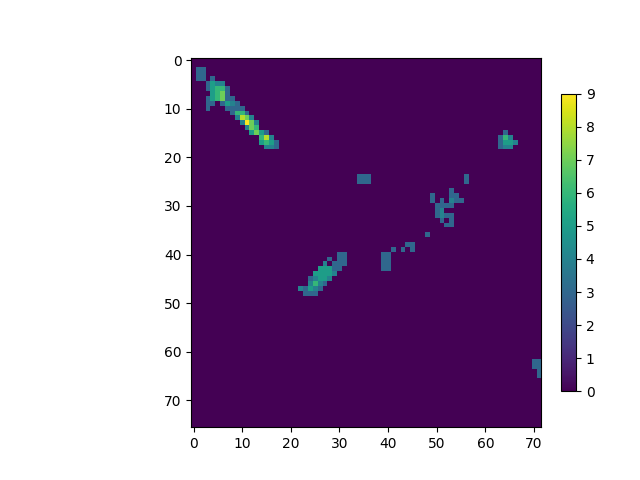

In [2]:
output_viz_file = '/home/yulun/code/segment_track/outputs/distfeatpca_output_viz.pkl'
pkl_file = open(output_viz_file, 'rb')
submaps_0, submaps_1, associated_objs_mat, robots_nearby_mat, T_ij_mat, T_ij_hat_mat = pickle.load(pkl_file)
pkl_file.close()
print(f'Loaded {len(submaps_0)} and {len(submaps_1)} submaps.')
clipper_num_associations  =  np.zeros((len(submaps_0), len(submaps_1)))*np.nan

max_i = 0
max_j = 0
max_num = 0
for i in range(len(submaps_0)):
  for j in range(len(submaps_1)):
    clipper_num_associations[i, j] =  len(associated_objs_mat[i][j])
    if len(associated_objs_mat[i][j]) > max_num:
      max_num = len(associated_objs_mat[i][j])
      max_i = i
      max_j = j

plt.imshow(
  clipper_num_associations, 
  vmin=0, 
)
plt.colorbar(fraction=0.03, pad=0.04)
plt.show()

In [3]:


# Same dir
idx_0 = max_i
idx_1 = max_j

# Opposite dir


association = associated_objs_mat[idx_0][idx_1]
submap_0 = [PointCloudObject.from_pickle(data) for data in submaps_0[idx_0]]
submap_1 = [PointCloudObject.from_pickle(data) for data in submaps_1[idx_1]]
print(f'Submap pair ({idx_0}, {idx_1}) contains {len(submap_0)} and {len(submap_1)} objects.')
print(f'Clipper finds {len(association)} associations.')


Submap pair (13, 11) contains 45 and 41 objects.
Clipper finds 9 associations.


In [4]:
# Prepare submaps for visualization
ocd_list_0 = []
ocd_list_1 = []
edges = []
red_color = np.asarray([1,0,0]).reshape((1,3))
blue_color = np.asarray([0,0,1]).reshape((1,3))
for seg in submap_0:
  pcd = o3d.geometry.PointCloud()
  pcd.points = o3d.utility.Vector3dVector(seg.get_points())
  num_pts = seg.get_points().shape[0]
  rand_color = np.random.uniform(0, 1) * red_color
  rand_color = np.repeat(rand_color, num_pts, axis=0)
  pcd.colors = o3d.utility.Vector3dVector(rand_color)
  ocd_list_0.append(pcd)

for seg in submap_1:
  pcd = o3d.geometry.PointCloud()
  pcd.points = o3d.utility.Vector3dVector(seg.get_points())
  num_pts = seg.get_points().shape[0]
  rand_color = np.random.uniform(0, 1) * blue_color
  rand_color = np.repeat(rand_color, num_pts, axis=0)
  pcd.colors = o3d.utility.Vector3dVector(rand_color)
  pcd.translate(np.asarray([20,0,0]))
  ocd_list_1.append(pcd)

for obj_idx_0, obj_idx_1 in association:
  print(f'Add edge between {obj_idx_0} and {obj_idx_1}.')
  points = [ocd_list_0[obj_idx_0].get_center(), ocd_list_1[obj_idx_1].get_center()]
  line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(points),
    lines=o3d.utility.Vector2iVector([[0,1]]),
  )
  line_set.colors = o3d.utility.Vector3dVector([[0,1,0]])
  edges.append(line_set)



Add edge between 8 and 9.
Add edge between 40 and 40.
Add edge between 5 and 5.
Add edge between 33 and 35.
Add edge between 31 and 29.
Add edge between 30 and 30.
Add edge between 4 and 7.
Add edge between 17 and 14.
Add edge between 15 and 16.


In [5]:
draw(ocd_list_0 + ocd_list_1 + edges)

[Open3D INFO] Window window_0 created.
[Open3D INFO] EGL headless mode enabled.
[Open3D INFO] ICE servers: {"stun:stun.l.google.com:19302", "turn:user:password@34.69.27.100:3478", "turn:user:password@34.69.27.100:3478?transport=tcp"}
FEngine (64 bits) created at 0x7f6140819010 (threading is enabled)
[Open3D INFO] Set WEBRTC_STUN_SERVER environment variable add a customized WebRTC STUN server.
[Open3D INFO] WebRTC Jupyter handshake mode enabled.
EGL(1.5)
OpenGL(4.1)


WebVisualizer(window_uid='window_0')

[Open3D INFO] [Called HTTP API (custom handshake)] /api/getIceServers
[Open3D INFO] [Called HTTP API (custom handshake)] /api/call
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/addIceCandidate
[Open3D INFO] [Called HTTP API (custom handshake)] /api/getIceCandidate
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: open, peerid: 0.49981964721648975
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: open, peerid: 0.49981964721648975
[Open3D INFO] Sending init frames to window_0.


[000:000][2583949] (stun_port.cc:96): Binding request timed out from 10.47.0.x:51370 (enp68s0)
